## Regression Project

Build a linear regression model that predicts the `price` column in the dataset on San Francisco Apartment rentals. Make sure to go through all the the relevant steps of the modelling workflow.

1. Data Cleaning has already been performed on this data
2. Explore the data, keeping an eye on useful features and potential issues 
3. Choose a model validation scheme (simple or cross validation)
4. Fit a Linear Regression Model
5. Evaluate your model - check assumptions, metrics, and coefficient estimates
6. Engineer Features as needed
7. Repeat Steps 2, 4, 5, 6 as needed
8. Once you are ready, fit your final model and report final model performance estimate by scoring on the test data. Report both test R-squared and MAE.

A reasonable goal is to get a validation MAE of <= 500 dollars.

Advice:

1. "Perfect" is the enemy of "Good".
2. You will not get to an MAE of 0, we don't have perfect data, and there is some randomness and emotion in how things like apartment prices are set. 
3. Modelling is challenging, especially if you're new. There isn't a "right" answer, but some models are better than others. Remember - "All Models are wrong, but some are useful" 
4. We will likely end up with different models and performance metrics, and that's ok. You can always implement new ideas after watching the solution video. I didn't do anything too fancy, so you might think of some great ideas I didn't!
5. Enjoy the process, and remember that at some point it's time to let the model go. No amount of feature engineering will achieve a perfect model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

df = pd.read_csv("sf_clean.csv") 

def district_mapping(value):
    if value in [2.0, 3.0, 10.0]:
        return "southwest"
    elif value in [1.0]:
        return "west"
    elif value in [4.0, 5.0, 6.0]:
        return "central"
    elif value in [7.0]:
        return "marina"
    elif value in [8.0]:
        return "north beach"
    else:
        return "FiDi/SOMA"
    

def parking_mapping(value):
    if value in ['(c) off-street', "(b) protected"]:
        return "off-street or prot"
    else:
        return value

df['hood_district'] = df['hood_district'].apply(district_mapping)
df["pets"] = np.where(df["pets"] == "(d) no pets", 0, 1)
df["parking"] = df["parking"].apply(parking_mapping)
df["sqft2"] = df["sqft"] ** 2
df["sqft3"] = df["sqft"] ** 3
df["laundry"] = np.where(df["laundry"] ==  "(a) in-unit", 1, 0)
df["housing_type"] = np.where(df["housing_type"] == "(a) single", 0, 1)
df["sqft_bath"] = df["sqft"] * df["bath"]
df["beds_bath_ratio"] = df["beds"] / df["bath"]
# df["price"] = np.log(df["price"])

df = df.drop([11, 253])
df = df.reset_index(drop=True)

df = pd.get_dummies(df, drop_first=True, dtype=int)


df.head()

,price,sqft,beds,bath,laundry,pets,housing_type,sqft2,sqft3,sqft_bath,beds_bath_ratio,parking_(d) no parking,parking_off-street or prot,hood_district_central,hood_district_marina,hood_district_north beach,hood_district_southwest,hood_district_west
0,6800,1600.0,2.0,2.0,1,0,1,2560000.0,4.096000e+09,3200.0,1.0,0,1,0,1,0,0,0
1,3500,550.0,1.0,1.0,1,1,1,302500.0,1.663750e+08,550.0,1.0,0,1,0,1,0,0,0
2,5100,1300.0,2.0,1.0,1,1,1,1690000.0,2.197000e+09,1300.0,2.0,1,0,0,1,0,0,0
3,9000,3500.0,3.0,2.5,1,0,1,12250000.0,4.287500e+10,8750.0,1.2,0,1,0,1,0,0,0
4,3100,561.0,1.0,1.0,0,1,1,314721.0,1.765585e+08,561.0,1.0,1,0,0,1,0,0,0


In [2]:
# df["parking"].value_counts()

In [3]:
# sns.barplot(df.groupby("hood_district")["price"].mean())

In [4]:
# df.groupby("hood_district")["price"].mean()


In [5]:
# df.corr(numeric_only=True)

### Data Dictionary

1. Price: The price of the rental and our target variable
2. sqft: The area in square feet of the rental
3. beds: The number of bedrooms in the rental
4. bath: The number of bathrooms in the rental
5. laundry: Does the rental have a laundry machine inside the house, a shared laundry machine, or no laundry on site?
6. pets: Does the rental allow pets? Cats only, dogs only or both cats and dogs?
7. Housing type: Is the rental in a multi-unit building, a building with two units, or a stand alone house? 
8. Parking: Does the apartment off a parking space? No, protected in a garage, off-street in a parking lot, or valet service?
9. Hood district: Which part of San Francisco is the apartment located?

![image info](SFAR_map.png)

In [20]:
cols = ["sqft", "beds", "bath", "parking_(d) no parking", "parking_off-street or prot", "hood_district_central", "hood_district_marina", "hood_district_north beach", "hood_district_southwest", "hood_district_west", "laundry"]

from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae
from sklearn.model_selection import train_test_split

kf = KFold(n_splits=5, shuffle=True, random_state=123)

tr_r2s = []
tr_maes = []
val_r2s = []
val_maes = []

X = sm.add_constant(df[cols])
y = df["price"]
y = np.log(df["price"])


X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


for train_ind, val_ind in kf.split(X, y):
    X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
    X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]
    
    model = sm.OLS(y_train, X_train).fit()
    tr_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    tr_preds_orig = np.exp(tr_preds)
    y_tr_orig = np.exp(y_train)
    val_preds_orig = np.exp(val_preds)
    y_val_orig = np.exp(y_val)
    
    
    # tr_r2s.append(r2(y_train, tr_preds))
    # tr_maes.append(mae(y_train, tr_preds))
    # val_r2s.append(r2(y_val, val_preds))
    # val_maes.append(mae(y_val, val_preds))

    tr_r2s.append(r2(y_tr_orig, tr_preds_orig))
    tr_maes.append(mae(y_tr_orig, tr_preds_orig))
    val_r2s.append(r2(y_val_orig, val_preds_orig))
    val_maes.append(mae(y_val_orig, val_preds_orig))
    

# print("Train R2s: ", [round(x, 3) for x in tr_r2s])
print(f"Train r2: {round(np.mean(tr_r2s), 3)} +- {round(np.std(tr_r2s), 3)}")
print()
# print("Train MAEs: ", [round(x, 3) for x in tr_maes])
print(f"Train MAE: {round(np.mean(tr_maes), 3)} +- {round(np.std(tr_maes), 3)}")
print()

# print("Val R2s: ", [round(x, 3) for x in val_r2s])
print(f"CV r2: {round(np.mean(val_r2s), 3)} +- {round(np.std(val_r2s), 3)}")
print()
# print("Val MAEs: ", [round(x, 3) for x in val_maes])
print(f"CV MAE: {round(np.mean(val_maes), 3)} +- {round(np.std(val_maes), 3)}")

model = sm.OLS(y, X).fit()
model.summary()

Train r2: 0.764 +- 0.01

Train MAE: 467.124 +- 8.216

CV r2: 0.741 +- 0.05

CV MAE: 479.079 +- 27.195


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     291.6
Date:                Thu, 27 Jun 2024   Prob (F-statistic):          5.03e-267
Time:                        16:33:57   Log-Likelihood:                 316.25
No. Observations:                 789   AIC:                            -608.5
Df Residuals:                     777   BIC:                            -552.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          7.6799      0.038    203.134      0.000       7.606       7.754
sqft                           0.0004   2.35e-05     16.311      0.000       0.000       0.000
beds                           0.1069      0.009     12.006      0.000       0.089       0.124
bath                           0.0348      0.016      2.153      0.032       0.003       0.066
parking_(d) no parking        -0.2452      0.033     -7.342      0.000      -0.311      -0.180
parking_off-street or prot    -0.1610      0.032     -4.984      0.000      -0.224      -0.098
hood_district_central          0.0247      0.018      1.403      0.161      -0.010       0.059
hood_district_marina           0.0838      0.021      3.986      0.000       0.043       0.125
hood_district_north beach     -0.0259      0.017     -1.517      0.130      -0.059       0.008
hood_district_southwest       -0.1764      0.022     -8.168      0.000      -0.219      -0.134
hood_district_west            -0.0546      0.031     -1.773      0.077      -0.115       0.006
laundry                        0.0828      0.014      6.020      0.000       0.056       0.110
==============================================================================
Omnibus:                        9.808   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.713
Skew:                           0.205   Prob(JB):                      0.00472
Kurtosis:                       3.397   Cond. No.                     1.05e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
influence = model.get_influence()
inf_summary_df = influence.summary_frame()
inf_summary_df.head()
inf_summary_df["cooks_d"].sort_values(ascending=False).round(2)

600    0.04
596    0.03
3      0.03
861    0.03
765    0.03
       ... 
302    0.00
736    0.00
263    0.00
867    0.00
371    0.00
Name: cooks_d, Length: 789, dtype: float64

## EDA


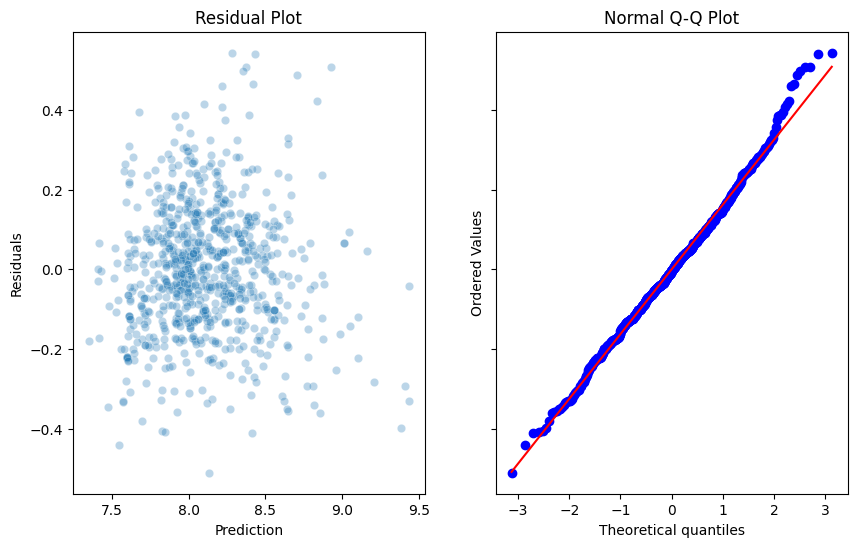

In [22]:
def residual_analysis_plots(model):

    import scipy.stats as stats
    import matplotlib.pyplot as plt

    predictions = model.predict()
    residuals = model.resid

    fig, ax = plt.subplots(1, 2, sharey="all", figsize=(10, 6))
    
    sns.scatterplot(x=predictions, y=residuals, ax=ax[0], alpha=0.3)
    ax[0].set_title("Residual Plot")
    ax[0].set_xlabel("Prediction")
    ax[0].set_ylabel("Residuals")

    stats.probplot(residuals, dist="norm", plot=ax[1])
    ax[1].set_title("Normal Q-Q Plot")

residual_analysis_plots(model)

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

pd.Series(
    [vif(X.values, i) for i in range(X.shape[1])],
    index = X.columns
)

const                         42.285701
sqft                           3.433333
beds                           2.682813
bath                           2.254438
parking_(d) no parking         8.229303
parking_off-street or prot     7.711821
hood_district_central          1.376784
hood_district_marina           1.334824
hood_district_north beach      1.436081
hood_district_southwest        1.284578
hood_district_west             1.155339
laundry                        1.399524
dtype: float64

In [24]:
# sns.pairplot(df)

In [25]:
# print(mae(np.exp(y_test), np.exp(model.predict(X_test))))
print(f"Test MAE: {mae(y_test, model.predict(X_test))}")
print(f"Test R2: {r2(y_test, model.predict(X_test))}")

490.9758635750456
Test R2: 0.7830367777778535


## Feature Engineering


In [607]:
y_test

911    8.433812
801    8.342840
421    8.476371
866    7.693937
182    8.216088
         ...   
299    8.612503
274    7.696213
606    7.377759
376    7.937375
335    8.236156
Name: price, Length: 198, dtype: float64

## Data Splitting

## Model Fitting & Validation Scoring

## Assumptions Checking

## Final Model Fit & Test Scoring